In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib notebook

import sys
sys.path.append('../')
from src.analysis.get_p_value import get_p_value

# Get Data

In [2]:
data_path = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/data_processed'

In [3]:
df = pd.read_hdf(os.path.join(data_path, 'processed_labeled.h5'), key='processed')

# Define Signal and Background Regions

In [4]:
df2 = df[(df['mass_jj'] >= 2950) & (df['mass_jj'] <= 4150)].copy().reset_index(drop=True)

In [5]:
df2['signal_region'] = ((df2['mass_jj'] >= 3250) & (df2['mass_jj'] <= 3750)).astype('int64')

# Classify

In [6]:
feature_cols = ['sqrt(tau1(2))/tau1(1)_1', 'tau21_1', 'tau32_1', 'tau43_1',
                'multiplicity_1', 'sqrt(tau1(2))/tau1(1)_2', 'tau21_2', 'tau32_2',
                'tau43_2', 'multiplicity_2', 'delta_phi_jj', 'mass_1+mass_2',
                '|mass_1-mass_2|']

## $S/B = 1/10$, original ratio

In [7]:
%%time
X = df2[feature_cols]
y = df2['signal_region']
spliter = StratifiedKFold(n_splits=5, shuffle=True)
df_xgb = pd.DataFrame(columns=['index', 'xgb_score'])
for tr_idx, te_idx in spliter.split(X, y):
    quant = QuantileTransformer()
    X_tr = quant.fit_transform(X.iloc[tr_idx])
    X_te = quant.transform(X.iloc[te_idx])
    y_tr = y.iloc[tr_idx]
    y_te = y.iloc[te_idx]
    
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_tr, y_tr)
    df_xgb = df_xgb.append(pd.DataFrame(data={'index': te_idx, 'xgb_score': clf.predict_proba(X_te).T[1]}))
    print(roc_auc_score(y_te, clf.predict_proba(X_te).T[1]), average_precision_score(y_te, clf.predict_proba(X_te).T[1]))

0.6337736390335122 0.6761752411161062
0.6355001367694407 0.6802283131589659
0.6312795505089907 0.676852684370989
0.6329373307526444 0.6763476376732372
0.631016211021963 0.6747289516928653
CPU times: user 44.1 s, sys: 886 ms, total: 44.9 s
Wall time: 45.3 s


In [8]:
df3 = df2.merge(df_xgb, how='left', left_index=True, right_on='index').drop(columns=['index'])

In [9]:
hist_1p0 = np.histogram(df3[df3['xgb_score'] > df3['xgb_score'].quantile(0.)]['mass_jj'], bins=np.arange(2950, 4150, 10))
hist_0p6 = np.histogram(df3[df3['xgb_score'] > df3['xgb_score'].quantile(0.4)]['mass_jj'], bins=np.arange(2950, 4150, 10))
hist_0p2 = np.histogram(df3[df3['xgb_score'] > df3['xgb_score'].quantile(0.8)]['mass_jj'], bins=np.arange(2950, 4150, 10))

In [10]:
hist_1p0b = np.histogram(df3[(df3['xgb_score'] > df3['xgb_score'].quantile(0.)) & (df3['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 10))
hist_0p6b = np.histogram(df3[(df3['xgb_score'] > df3['xgb_score'].quantile(0.4)) & (df3['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 10))
hist_0p2b = np.histogram(df3[(df3['xgb_score'] > df3['xgb_score'].quantile(0.8)) & (df3['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 10))

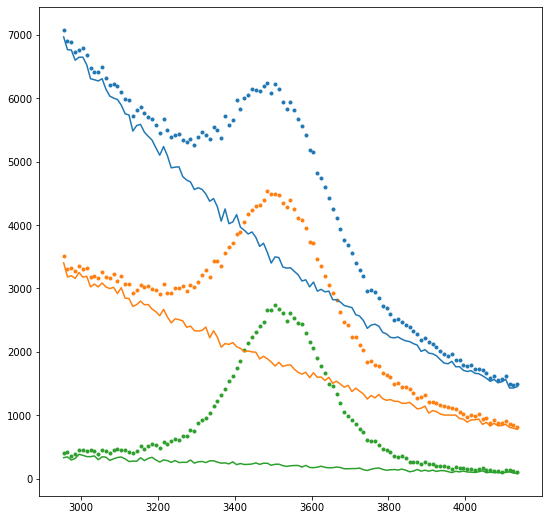

In [11]:
plt.figure(1, figsize=(9, 9))

plt.plot([(hist_1p0b[1][i]+hist_1p0b[1][i+1])/2 for i in range(len(hist_1p0b[1])-1)], hist_1p0b[0])
plt.scatter([(hist_1p0[1][i]+hist_1p0[1][i+1])/2 for i in range(len(hist_1p0[1])-1)], hist_1p0[0], marker='.')

plt.plot([(hist_0p6b[1][i]+hist_0p6b[1][i+1])/2 for i in range(len(hist_0p6b[1])-1)], hist_0p6b[0])
plt.scatter([(hist_0p6[1][i]+hist_0p6[1][i+1])/2 for i in range(len(hist_0p6[1])-1)], hist_0p6[0], marker='.')

plt.plot([(hist_0p2b[1][i]+hist_0p2b[1][i+1])/2 for i in range(len(hist_0p2b[1])-1)], hist_0p2b[0])
plt.scatter([(hist_0p2[1][i]+hist_0p2[1][i+1])/2 for i in range(len(hist_0p2[1])-1)], hist_0p2[0], marker='.')
plt.show()

fit params:  [ 2.33095956e+13  3.28026591e+01 -7.54571129e+00]


Goodness:  KstestResult(statistic=0.08727963011399498, pvalue=0.670690112023088)


numerator:  dict_items([('fun', -445.31631169561297), ('jac', array([-0.3259629])), ('nfev', 16), ('nit', 2), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([1529.29918716])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -8126.510447492357), ('jac', array([0.04656613, 0.04656613])), ('nfev', 156), ('nit', 4), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([ 5668.73114758, 50967.16865923])), ('success', False), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  123.94747421356544
p0 =  0.0


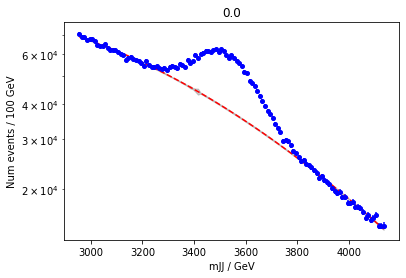

(0.0, 15362.97636392247)

In [12]:
get_p_value(
    hist_1p0[0], 
    hist_1p0[1],
    np.arange(np.where(hist_1p0[1]==3250)[0][0], np.where(hist_1p0[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

## $S/B = 1/100$

In [13]:
%%time
df4 = (df2[df2['is_signal'] == 1].sample(frac=0.1)).append(df2[df2['is_signal'] == 0]).sample(frac=1.).reset_index(drop=True)
X = df4[feature_cols]
y = df4['signal_region']
spliter = StratifiedKFold(n_splits=5, shuffle=True)
df_xgb2 = pd.DataFrame(columns=['index', 'xgb_score'])
for tr_idx, te_idx in spliter.split(X, y):
    quant = QuantileTransformer()
    X_tr = quant.fit_transform(X.iloc[tr_idx])
    X_te = quant.transform(X.iloc[te_idx])
    y_tr = y.iloc[tr_idx]
    y_te = y.iloc[te_idx]
    
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_tr, y_tr)
    df_xgb2 = df_xgb2.append(pd.DataFrame(data={'index': te_idx, 'xgb_score': clf.predict_proba(X_te).T[1]}))
    print(roc_auc_score(y_te, clf.predict_proba(X_te).T[1]), average_precision_score(y_te, clf.predict_proba(X_te).T[1]))

0.5333221482494648 0.4765492434021643
0.5324504419319632 0.47533942724638695
0.5354304942623881 0.476982148911975
0.5316546732101951 0.4741876251900581
0.5352358666669421 0.47878537433923535
CPU times: user 33.7 s, sys: 729 ms, total: 34.4 s
Wall time: 34.4 s


In [14]:
df5 = df4.merge(df_xgb2, how='left', left_index=True, right_on='index').drop(columns=['index'])

In [15]:
hist_1p0 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.4)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.8)]['mass_jj'], bins=np.arange(2950, 4150, 20))

In [16]:
hist_1p0b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.4)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.8)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))

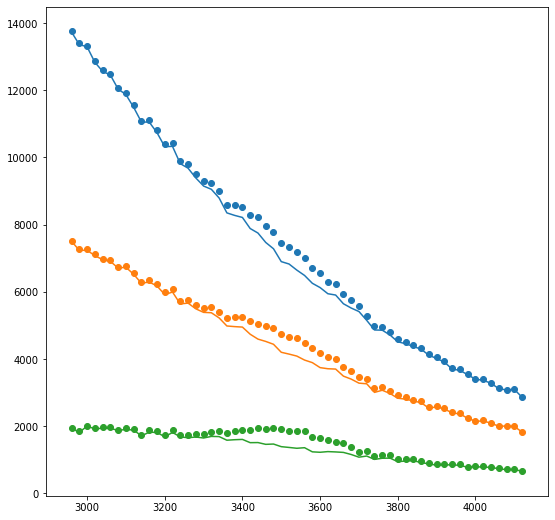

In [17]:
plt.figure(2, figsize=(9, 9))

plt.plot([(hist_1p0b[1][i]+hist_1p0b[1][i+1])/2 for i in range(len(hist_1p0b[1])-1)], hist_1p0b[0])
plt.scatter([(hist_1p0[1][i]+hist_1p0[1][i+1])/2 for i in range(len(hist_1p0[1])-1)], hist_1p0[0])

plt.plot([(hist_0p6b[1][i]+hist_0p6b[1][i+1])/2 for i in range(len(hist_0p6b[1])-1)], hist_0p6b[0])
plt.scatter([(hist_0p6[1][i]+hist_0p6[1][i+1])/2 for i in range(len(hist_0p6[1])-1)], hist_0p6[0])

plt.plot([(hist_0p2b[1][i]+hist_0p2b[1][i+1])/2 for i in range(len(hist_0p2b[1])-1)], hist_0p2b[0])
plt.scatter([(hist_0p2[1][i]+hist_0p2[1][i+1])/2 for i in range(len(hist_0p2[1])-1)], hist_0p2[0])
plt.show()

fit params:  [ 3.92948119e+08  1.94082954e+01 -2.45326013e+00]


Goodness:  KstestResult(statistic=0.08621571491874605, pvalue=0.9668890381762937)


numerator:  dict_items([('fun', -15.505352352745831), ('jac', array([0.])), ('nfev', 18), ('nit', 2), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([508.70839025])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -0.03221625089645386), ('jac', array([0., 0.])), ('nfev', 6), ('nit', 1), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([0.01, 2.  ])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  nan
p0 =  nan


../src/analysis/get_p_value.py:236: RuntimeWarning: invalid value encountered in sqrt
  Zval = np.sqrt(2*(neglognum - neglogden))


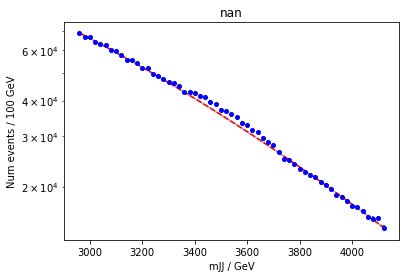

(nan, -30.882473090663552)

In [18]:
get_p_value(
    hist_1p0[0], 
    hist_1p0[1],
    np.arange(np.where(hist_1p0[1]==3250)[0][0], np.where(hist_1p0[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 1.59635998e+10  2.37973505e+01 -4.60364657e+00]


Goodness:  KstestResult(statistic=0.06995295620347702, pvalue=0.9970002086929567)


numerator:  dict_items([('fun', -56.98721999162808), ('jac', array([-0.04656613])), ('nfev', 22), ('nit', 3), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([1143.34768385])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -159.08069776021875), ('jac', array([0., 0.])), ('nfev', 36), ('nit', 3), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([3075.80965725, 2007.4265875 ])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  14.293304062006113
p0 =  0.0


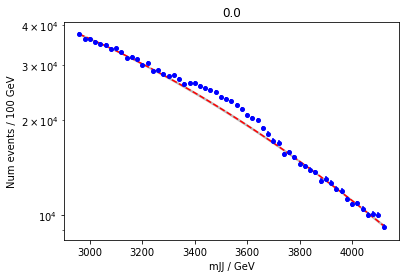

(0.0, 204.29854100896046)

In [19]:
get_p_value(
    hist_0p6[0], 
    hist_0p6[1],
    np.arange(np.where(hist_0p6[1]==3250)[0][0], np.where(hist_0p6[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

## $S/B = 1/200$

In [44]:
%%time
df4 = (df2[df2['is_signal'] == 1].sample(frac=0.05)).append(df2[df2['is_signal'] == 0]).sample(frac=1.).reset_index(drop=True)
X = df4[feature_cols]
y = df4['signal_region']
spliter = StratifiedKFold(n_splits=5, shuffle=True)
df_xgb2 = pd.DataFrame(columns=['index', 'xgb_score'])
for tr_idx, te_idx in spliter.split(X, y):
    quant = QuantileTransformer()
    X_tr = quant.fit_transform(X.iloc[tr_idx])
    X_te = quant.transform(X.iloc[te_idx])
    y_tr = y.iloc[tr_idx]
    y_te = y.iloc[te_idx]
    
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_tr, y_tr)
    df_xgb2 = df_xgb2.append(pd.DataFrame(data={'index': te_idx, 'xgb_score': clf.predict_proba(X_te).T[1]}))
    print(roc_auc_score(y_te, clf.predict_proba(X_te).T[1]), average_precision_score(y_te, clf.predict_proba(X_te).T[1]))

0.5213314383496226 0.45264809128522127
0.52734609226638 0.45763698526013696
0.5257063950038406 0.45354699984703967
0.5256211854202394 0.45410083313153193
0.527292851544936 0.45442249473453056
CPU times: user 35.2 s, sys: 901 ms, total: 36.1 s
Wall time: 36.3 s


In [45]:
df5 = df4.merge(df_xgb2, how='left', left_index=True, right_on='index').drop(columns=['index'])

In [46]:
hist_1p0 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.4)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.5)]['mass_jj'], bins=np.arange(2950, 4150, 20))

In [47]:
hist_1p0b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.4)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.5)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))

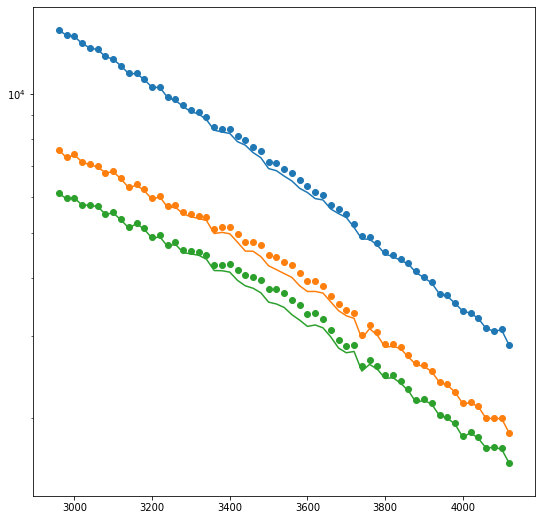

In [48]:
plt.figure(3, figsize=(9, 9))

plt.plot([(hist_1p0b[1][i]+hist_1p0b[1][i+1])/2 for i in range(len(hist_1p0b[1])-1)], hist_1p0b[0])
plt.scatter([(hist_1p0[1][i]+hist_1p0[1][i+1])/2 for i in range(len(hist_1p0[1])-1)], hist_1p0[0])

plt.plot([(hist_0p6b[1][i]+hist_0p6b[1][i+1])/2 for i in range(len(hist_0p6b[1])-1)], hist_0p6b[0])
plt.scatter([(hist_0p6[1][i]+hist_0p6[1][i+1])/2 for i in range(len(hist_0p6[1])-1)], hist_0p6[0])

plt.plot([(hist_0p2b[1][i]+hist_0p2b[1][i+1])/2 for i in range(len(hist_0p2b[1])-1)], hist_0p2b[0])
plt.scatter([(hist_0p2[1][i]+hist_0p2[1][i+1])/2 for i in range(len(hist_0p2[1])-1)], hist_0p2[0])

plt.yscale('log')
plt.show()

fit params:  [ 2.28005073e+08  1.87456563e+01 -2.20125331e+00]


Goodness:  KstestResult(statistic=0.09235825381227508, pvalue=0.9409848902898493)


numerator:  dict_items([('fun', -0.0011029667221009731), ('jac', array([0.02328306])), ('nfev', 84), ('nit', 1), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([0.08984919])), ('success', False), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -17.958403834840283), ('jac', array([ 0.        , -0.02328306])), ('nfev', 117), ('nit', 5), ('status', 0), ('message', b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'), ('x', array([2439.47064813, -141.87376744])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  0
p0 =  0.5


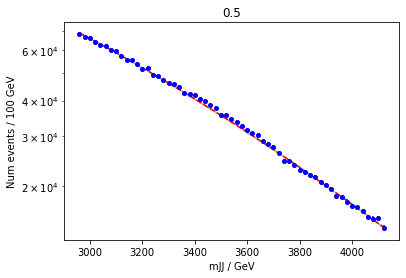

(0.5, 0)

In [49]:
get_p_value(
    hist_1p0[0], 
    hist_1p0[1],
    np.arange(np.where(hist_1p0[1]==3250)[0][0], np.where(hist_1p0[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 5.62720554e+09  2.25192233e+01 -4.11688074e+00]


Goodness:  KstestResult(statistic=0.09515287829291696, pvalue=0.9261790037600721)


numerator:  dict_items([('fun', -24.721980150556192), ('jac', array([0.])), ('nfev', 20), ('nit', 2), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([1017.30364825])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -39.315917952219024), ('jac', array([0., 0.])), ('nfev', 27), ('nit', 1), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([3.17729123e+03, 1.00000000e+00])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  5.408074319787625
p0 =  3.185299513042139e-08


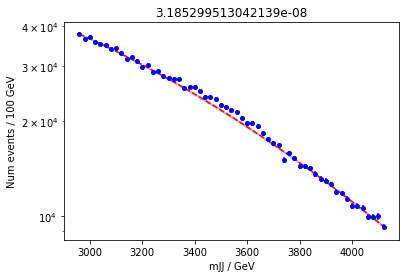

(3.185299513042139e-08, 29.247267848346382)

In [50]:
get_p_value(
    hist_0p6[0], 
    hist_0p6[1],
    np.arange(np.where(hist_0p6[1]==3250)[0][0], np.where(hist_0p6[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

## $S/B = 1/333$

In [52]:
%%time
df4 = (df2[df2['is_signal'] == 1].sample(frac=0.03)).append(df2[df2['is_signal'] == 0]).sample(frac=1.).reset_index(drop=True)
X = df4[feature_cols]
y = df4['signal_region']
spliter = StratifiedKFold(n_splits=5, shuffle=True)
df_xgb2 = pd.DataFrame(columns=['index', 'xgb_score'])
for tr_idx, te_idx in spliter.split(X, y):
    quant = QuantileTransformer()
    X_tr = quant.fit_transform(X.iloc[tr_idx])
    X_te = quant.transform(X.iloc[te_idx])
    y_tr = y.iloc[tr_idx]
    y_te = y.iloc[te_idx]
    
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_tr, y_tr)
    df_xgb2 = df_xgb2.append(pd.DataFrame(data={'index': te_idx, 'xgb_score': clf.predict_proba(X_te).T[1]}))
    print(roc_auc_score(y_te, clf.predict_proba(X_te).T[1]), average_precision_score(y_te, clf.predict_proba(X_te).T[1]))

0.5219481576172231 0.4435828004280985
0.5226136768298562 0.44468262931206515
0.525390935294372 0.44939459987441177
0.5220384420343703 0.4445557602033712
0.5233913141770947 0.4466818831171033
CPU times: user 36.1 s, sys: 1.06 s, total: 37.1 s
Wall time: 37.6 s


In [53]:
df5 = df4.merge(df_xgb2, how='left', left_index=True, right_on='index').drop(columns=['index'])

In [54]:
hist_1p0 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.4)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.8)]['mass_jj'], bins=np.arange(2950, 4150, 20))

In [55]:
hist_1p0b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.4)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.8)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))

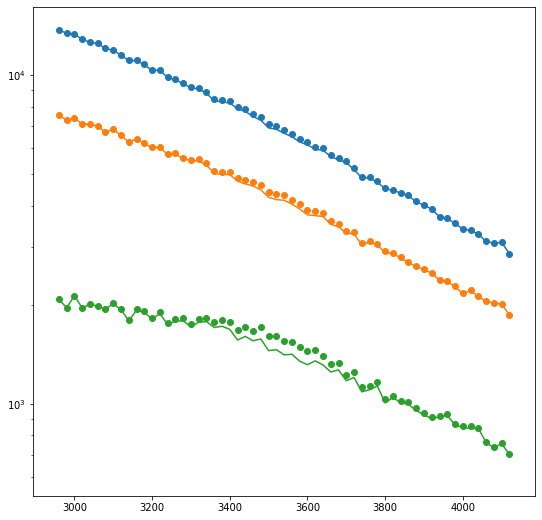

In [56]:
plt.figure(4, figsize=(9, 9))

plt.plot([(hist_1p0b[1][i]+hist_1p0b[1][i+1])/2 for i in range(len(hist_1p0b[1])-1)], hist_1p0b[0])
plt.scatter([(hist_1p0[1][i]+hist_1p0[1][i+1])/2 for i in range(len(hist_1p0[1])-1)], hist_1p0[0])

plt.plot([(hist_0p6b[1][i]+hist_0p6b[1][i+1])/2 for i in range(len(hist_0p6b[1])-1)], hist_0p6b[0])
plt.scatter([(hist_0p6[1][i]+hist_0p6[1][i+1])/2 for i in range(len(hist_0p6[1])-1)], hist_0p6[0])

plt.plot([(hist_0p2b[1][i]+hist_0p2b[1][i+1])/2 for i in range(len(hist_0p2b[1])-1)], hist_0p2b[0])
plt.scatter([(hist_0p2[1][i]+hist_0p2[1][i+1])/2 for i in range(len(hist_0p2[1])-1)], hist_0p2[0])

plt.yscale('log')
plt.show()

fit params:  [ 1.77937357e+08  1.84419903e+01 -2.08679909e+00]


Goodness:  KstestResult(statistic=0.09088645447287635, pvalue=0.9480250398975618)


numerator:  dict_items([('fun', -0.07492160121910274), ('jac', array([0.02328306])), ('nfev', 100), ('nit', 2), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([7.98280801])), ('success', False), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', 0.0), ('jac', array([0.02328306, 0.02328306])), ('nfev', 63), ('nit', 0), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([0.01, 1.  ])), ('success', False), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  nan
p0 =  nan


../src/analysis/get_p_value.py:236: RuntimeWarning: invalid value encountered in sqrt
  Zval = np.sqrt(2*(neglognum - neglogden))


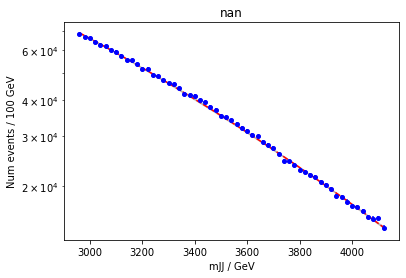

(nan, -0.1311652292497456)

In [57]:
get_p_value(
    hist_1p0[0], 
    hist_1p0[1],
    np.arange(np.where(hist_1p0[1]==3250)[0][0], np.where(hist_1p0[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 3.81190041e+09  2.20206826e+01 -3.94031095e+00]


Goodness:  KstestResult(statistic=0.08920404985356134, pvalue=0.9554273219327035)


numerator:  dict_items([('fun', -0.010792318033054471), ('jac', array([0.])), ('nfev', 10), ('nit', 2), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([0.53222742])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -22.946955068269745), ('jac', array([0., 0.])), ('nfev', 21), ('nit', 1), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([965.21075632, 966.20075632])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  6.775989946443897
p0 =  6.1778360205266836e-12


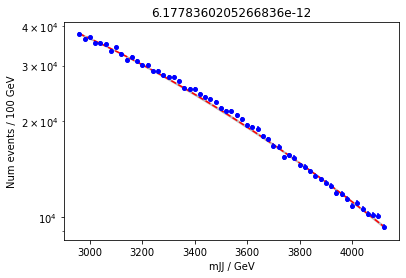

(6.1778360205266836e-12, 45.91403975430876)

In [58]:
get_p_value(
    hist_0p6[0], 
    hist_0p6[1],
    np.arange(np.where(hist_0p6[1]==3250)[0][0], np.where(hist_0p6[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 1.55407196e+12  2.91752435e+01 -7.63171604e+00]


Goodness:  KstestResult(statistic=0.09960574655516319, pvalue=0.8988266418746937)


numerator:  dict_items([('fun', -36.428288066526875), ('jac', array([-0.04656613])), ('nfev', 16), ('nit', 3), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([626.5734715])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -84.67740391806001), ('jac', array([0., 0.])), ('nfev', 39), ('nit', 6), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([ 892.54260523, 1480.86479827])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  9.830284186045155
p0 =  0.0


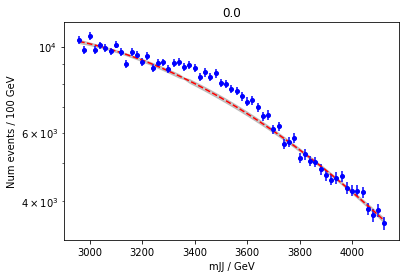

(0.0, 96.63448717840947)

In [59]:
get_p_value(
    hist_0p2[0], 
    hist_0p2[1],
    np.arange(np.where(hist_0p2[1]==3250)[0][0], np.where(hist_0p2[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

## $S/B = 1/500$

In [60]:
%%time
df4 = (df2[df2['is_signal'] == 1].sample(frac=0.02)).append(df2[df2['is_signal'] == 0]).sample(frac=1.).reset_index(drop=True)
X = df4[feature_cols]
y = df4['signal_region']
spliter = StratifiedKFold(n_splits=5, shuffle=True)
df_xgb2 = pd.DataFrame(columns=['index', 'xgb_score'])
for tr_idx, te_idx in spliter.split(X, y):
    quant = QuantileTransformer()
    X_tr = quant.fit_transform(X.iloc[tr_idx])
    X_te = quant.transform(X.iloc[te_idx])
    y_tr = y.iloc[tr_idx]
    y_te = y.iloc[te_idx]
    
    clf = XGBClassifier(tree_method='hist')
    clf.fit(X_tr, y_tr)
    df_xgb2 = df_xgb2.append(pd.DataFrame(data={'index': te_idx, 'xgb_score': clf.predict_proba(X_te).T[1]}))
    print(roc_auc_score(y_te, clf.predict_proba(X_te).T[1]), average_precision_score(y_te, clf.predict_proba(X_te).T[1]))

0.5210601154308044 0.44001283842100086
0.521264375900372 0.44074484917714846
0.520613870824941 0.4402921152424477
0.5197665478886949 0.4389750350895256
0.5230138648895366 0.4420123858061422
CPU times: user 36.7 s, sys: 1.09 s, total: 37.8 s
Wall time: 38.2 s


In [61]:
df5 = df4.merge(df_xgb2, how='left', left_index=True, right_on='index').drop(columns=['index'])

In [62]:
hist_1p0 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.4)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2 = np.histogram(df5[df5['xgb_score'] > df5['xgb_score'].quantile(0.8)]['mass_jj'], bins=np.arange(2950, 4150, 20))

In [63]:
hist_1p0b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p6b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.4)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))
hist_0p2b = np.histogram(df5[(df5['xgb_score'] > df5['xgb_score'].quantile(0.8)) & (df5['is_signal'] == 0)]['mass_jj'], bins=np.arange(2950, 4150, 20))

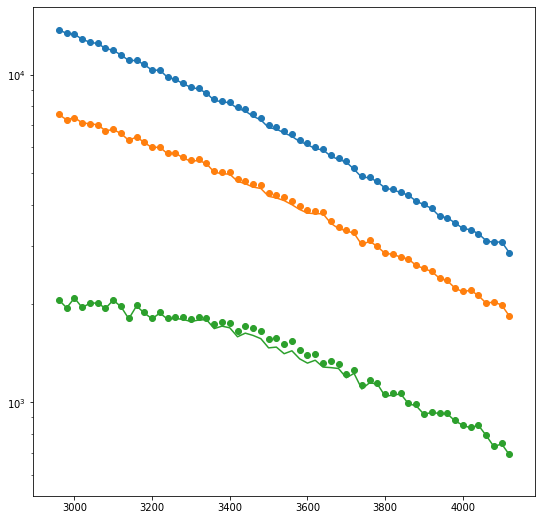

In [64]:
plt.figure(4, figsize=(9, 9))

plt.plot([(hist_1p0b[1][i]+hist_1p0b[1][i+1])/2 for i in range(len(hist_1p0b[1])-1)], hist_1p0b[0])
plt.scatter([(hist_1p0[1][i]+hist_1p0[1][i+1])/2 for i in range(len(hist_1p0[1])-1)], hist_1p0[0])

plt.plot([(hist_0p6b[1][i]+hist_0p6b[1][i+1])/2 for i in range(len(hist_0p6b[1])-1)], hist_0p6b[0])
plt.scatter([(hist_0p6[1][i]+hist_0p6[1][i+1])/2 for i in range(len(hist_0p6[1])-1)], hist_0p6[0])

plt.plot([(hist_0p2b[1][i]+hist_0p2b[1][i+1])/2 for i in range(len(hist_0p2b[1])-1)], hist_0p2b[0])
plt.scatter([(hist_0p2[1][i]+hist_0p2[1][i+1])/2 for i in range(len(hist_0p2[1])-1)], hist_0p2[0])

plt.yscale('log')
plt.show()

fit params:  [ 1.51274921e+08  1.82435402e+01 -2.01153916e+00]


Goodness:  KstestResult(statistic=0.0805061314463762, pvalue=0.9830597246932749)


numerator:  dict_items([('fun', 0.0), ('jac', array([0.02328306])), ('nfev', 42), ('nit', 0), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([0.02])), ('success', False), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', 0.0), ('jac', array([0.02328306, 0.02328306])), ('nfev', 63), ('nit', 0), ('status', 2), ('message', b'ABNORMAL_TERMINATION_IN_LNSRCH'), ('x', array([0.01, 1.  ])), ('success', False), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  0.10983321732207169
p0 =  0.4562708233943549


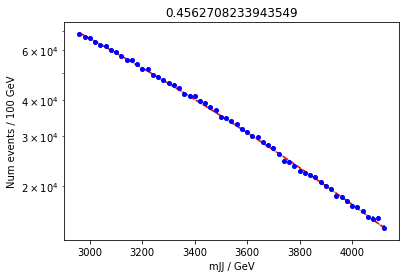

(0.4562708233943549, 0.012063335627317429)

In [65]:
get_p_value(
    hist_1p0[0], 
    hist_1p0[1],
    np.arange(np.where(hist_1p0[1]==3250)[0][0], np.where(hist_1p0[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 4.59752717e+09  2.23018180e+01 -4.01529800e+00]


Goodness:  KstestResult(statistic=0.10460422633602978, pvalue=0.8630814758338836)


numerator:  dict_items([('fun', -0.0035004252567887306), ('jac', array([0.])), ('nfev', 8), ('nit', 2), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([0.27611371])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -0.2848748522810638), ('jac', array([0., 0.])), ('nfev', 12), ('nit', 1), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([1.0e-02, 2.2e+01])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  0.7679873138999459
p0 =  0.22124736088767538


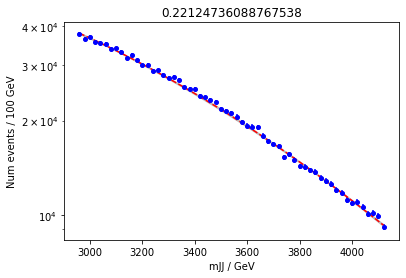

(0.22124736088767538, 0.589804514311254)

In [66]:
get_p_value(
    hist_0p6[0], 
    hist_0p6[1],
    np.arange(np.where(hist_0p6[1]==3250)[0][0], np.where(hist_0p6[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

fit params:  [ 1.59012103e+13  3.20146638e+01 -8.71292124e+00]


Goodness:  KstestResult(statistic=0.13841601533746922, pvalue=0.5164943013212244)


numerator:  dict_items([('fun', -20.460574165044818), ('jac', array([-0.02328306])), ('nfev', 20), ('nit', 3), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([631.41449875])), ('success', True), ('hess_inv', <1x1 LbfgsInvHessProduct with dtype=float64>)]) 

Denominator:  dict_items([('fun', -34.22264472238021), ('jac', array([0., 0.])), ('nfev', 39), ('nit', 4), ('status', 0), ('message', b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'), ('x', array([ 380.56116427, 1246.44478517])), ('success', True), ('hess_inv', <2x2 LbfgsInvHessProduct with dtype=float64>)]) 

z =  5.254400841916363
p0 =  7.425356429724417e-08


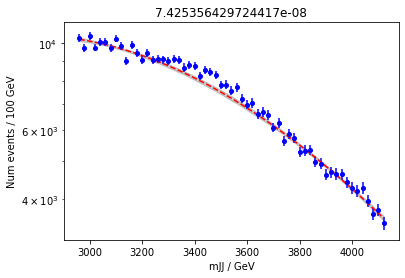

(7.425356429724417e-08, 27.608728207531385)

In [67]:
get_p_value(
    hist_0p2[0], 
    hist_0p2[1],
    np.arange(np.where(hist_0p2[1]==3250)[0][0], np.where(hist_0p2[1]==3750)[0][0]+1),
    verbose=True, 
    plotfile='show', 
    return_teststat=True
)

# Plot